In [21]:
import tensorflow as tf
import tensorflow_addons as tfa
import random
print(tf.version.VERSION)

2.3.0


In [22]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras.layers import add, AveragePooling2D, Dense, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import SGDW
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.datasets.cifar10 import load_data

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [23]:
(X_train, y_train), (X_test, y_test) = load_data()

In [54]:
def augment(img, label):
    image = tf.cast(img, tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize_with_pad(image, 36, 36)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    image = (image / 255.0)
    return image, label

def normalize(img, label):
    image = tf.cast(img, tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize_with_pad(image, 36, 36)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    image = (image / 255.0)
    return image, label

In [55]:
X_train, X_val = X_train[5000:], X_train[:5000]
y_train, y_val = y_train[5000:], y_train[:5000]

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache().shuffle(2048).map(augment, AUTOTUNE)
train_dataset = train_dataset.batch(128).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.cache().shuffle(2048).map(augment, AUTOTUNE)
val_dataset = val_dataset.batch(128).prefetch(AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.cache().shuffle(2048).map(augment, AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(AUTOTUNE)

In [57]:
class ResNet:
    @staticmethod
    def residual_block(data, filters, strides, transition):
        shortcut = data

        x = Conv2D(filters, 3, strides, padding="same", kernel_initializer="he_normal", 
                   use_bias=False)(data)
        x = BatchNormalization(beta_initializer='zeros', gamma_initializer=RandomNormal(mean=0.0, stddev=1.0))(x)
        x = Activation("relu")(x)
        
        x = Conv2D(filters, 3, 1, padding="same", kernel_initializer="he_normal", 
                   use_bias=False)(x)
        x = BatchNormalization(beta_initializer='zeros', gamma_initializer=RandomNormal(mean=0.0, stddev=1.0))(x)
        x = Activation("relu")(x)
        
        if transition:
            shortcut = Conv2D(filters, 1, 2, padding="valid", kernel_initializer="he_normal", 
                              use_bias=False)(shortcut)
            shortcut = BatchNormalization(beta_initializer='zeros', 
                                          gamma_initializer=RandomNormal(mean=0.0, stddev=1.0))(shortcut)

        return add([shortcut, x])
    
    @staticmethod
    def build(num_blocks=2, filters_block=[16,32,64]):
        inputs = Input(shape=(32,32,3))
        x = Conv2D(16, 3, padding="same", kernel_initializer="he_normal", use_bias=False)(inputs)
        
        for i in range(3):
            for j in range(num_blocks):
                if j==0:
                    transition = True
                    strides = 2
                else:
                    transition = False
                    strides = 1
                    
                x = ResNet.residual_block(x, filters_block[i], strides, transition)
                
        avg_pool = AveragePooling2D(3)(x)
        x = Dense(10, use_bias=False, kernel_initializer='he_normal')(avg_pool)
        x = Flatten()(x)        
        outputs = Activation("softmax")(x)
                
        return tf.keras.Model(inputs=inputs, outputs=outputs)

In [58]:
model = ResNet.build(num_blocks=2)

In [59]:
count_conv = 0
for layer in model.layers:
    if not isinstance(layer, BatchNormalization):
        if hasattr(layer, 'trainable'):
            layer.trainable = False
    if isinstance(layer, Conv2D):
        count_conv += 1
print(f'Total Number of Conv layers: {count_conv - 2}')

Total Number of Conv layers: 14


In [60]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   432         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 16, 16, 16)   2304        conv2d_64[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 16, 16, 16)   64          conv2d_65[0][0]                  
_______________________________________________________________________________________

In [61]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [28125, 42185], [1e-0, 1e-1, 1e-2])

wd = lambda: 1e-4 * schedule(step)

model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [62]:
def scheduler(epoch, lr):
    if epoch in [80, 120]:
        return lr * 0.1
    return lr
    
callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)]

In [63]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=160, batch_size=128, callbacks=callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/160
313/313 [==============================] - 2s 7ms/step - loss: 2.0223 - accuracy: 0.2524 - val_loss: 1.9104 - val_accuracy: 0.2928

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/160
313/313 [==============================] - 2s 7ms/step - loss: 1.8265 - accuracy: 0.3335 - val_loss: 1.7939 - val_accuracy: 0.3414

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/160
313/313 [==============================] - 2s 7ms/step - loss: 1.7658 - accuracy: 0.3585 - val_loss: 1.7587 - val_accuracy: 0.3644

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/160
313/313 [==============================] - 2s 7ms/step - loss: 1.7321 - accuracy: 0.3673 - val_loss: 1.7299 - val_accuracy: 0.3680

Epoch 00005: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 5/160
3

313/313 [==============================] - 2s 7ms/step - loss: 1.5517 - accuracy: 0.4339 - val_loss: 1.5534 - val_accuracy: 0.4338

Epoch 00038: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 38/160
313/313 [==============================] - 2s 6ms/step - loss: 1.5478 - accuracy: 0.4347 - val_loss: 1.5422 - val_accuracy: 0.4362

Epoch 00039: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 39/160
313/313 [==============================] - 2s 6ms/step - loss: 1.5457 - accuracy: 0.4341 - val_loss: 1.5292 - val_accuracy: 0.4408

Epoch 00040: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 40/160
313/313 [==============================] - 2s 7ms/step - loss: 1.5441 - accuracy: 0.4378 - val_loss: 1.5329 - val_accuracy: 0.4434

Epoch 00041: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 41/160
313/313 [==============================] - 2s 7ms/step - loss: 1.5447 - accuracy: 0.4371 - v

313/313 [==============================] - 2s 7ms/step - loss: 1.4987 - accuracy: 0.4581 - val_loss: 1.4864 - val_accuracy: 0.4590

Epoch 00110: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 110/160
313/313 [==============================] - 2s 7ms/step - loss: 1.5005 - accuracy: 0.4539 - val_loss: 1.4899 - val_accuracy: 0.4502

Epoch 00111: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 111/160
313/313 [==============================] - 2s 6ms/step - loss: 1.5037 - accuracy: 0.4536 - val_loss: 1.4815 - val_accuracy: 0.4602

Epoch 00112: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 112/160
313/313 [==============================] - 2s 7ms/step - loss: 1.4980 - accuracy: 0.4575 - val_loss: 1.4906 - val_accuracy: 0.4570

Epoch 00113: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 113/160
313/313 [==============================] - 2s 7ms/step - loss: 1.5009 - accuracy: 0.

313/313 [==============================] - 2s 7ms/step - loss: 1.5002 - accuracy: 0.4556 - val_loss: 1.4862 - val_accuracy: 0.4588

Epoch 00146: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 146/160
313/313 [==============================] - 2s 7ms/step - loss: 1.4961 - accuracy: 0.4579 - val_loss: 1.4793 - val_accuracy: 0.4578

Epoch 00147: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 147/160
313/313 [==============================] - 2s 7ms/step - loss: 1.4924 - accuracy: 0.4591 - val_loss: 1.4886 - val_accuracy: 0.4588

Epoch 00148: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 148/160
313/313 [==============================] - 2s 7ms/step - loss: 1.4993 - accuracy: 0.4563 - val_loss: 1.4793 - val_accuracy: 0.4624

Epoch 00149: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 149/160
313/313 [==============================] - 2s 7ms/step - loss: 1.4975 - accuracy

In [66]:
model.evaluate(test_dataset)

79/79 [==============================] - 0s 3ms/step - loss: 1.4819 - accuracy: 0.4619


[1.4819425344467163, 0.461899995803833]

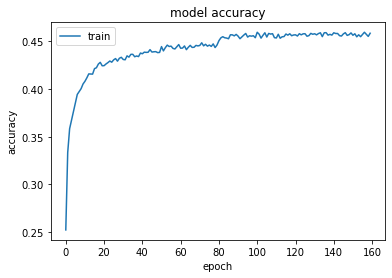

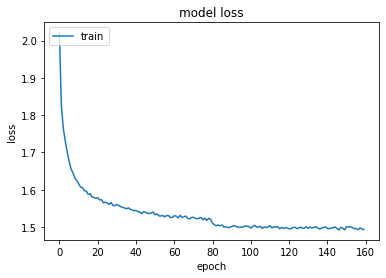

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()